# Imports

In [51]:
# Data Manipulation
import numpy as np
import pandas as pd

# Viewing images
from ipywidgets import interact
import matplotlib.pyplot as plt

# Classification
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

# Scene ID
from matplotlib.patches import Rectangle
from PIL import Image, ImageOps, ImageFilter

# Importing and Formatting Data

In [2]:
# Image data stored in the data column. 
# Stored as a list of 6400*3 ints. First 6400 are red, next are green, the blue. 
# Images are 80x80px
data_json = pd.read_json('shipsnet.json')
data_json.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
rgbs = data_json['data']
rgbs.head()

0    [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...
1    [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...
2    [125, 127, 129, 130, 126, 125, 129, 133, 132, ...
3    [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...
4    [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...
Name: data, dtype: object

In [4]:
rgbs = np.stack(rgbs) # Make 2d np array
r = rgbs[:,:6400]
g = rgbs[:,6400:6400*2]
b = rgbs[:,6400*2:]
r.shape, g.shape, b.shape

((4000, 6400), (4000, 6400), (4000, 6400))

$$Black\ and\ white = \frac{r + g + b}{3}$$

In [49]:
black_white = (r+g+b)/3
black_white.shape

(4000, 6400)

In [6]:
# Split data
test_vectors, train_vectors, test_labels, train_labels = train_test_split(black_white, data_json['labels'],test_size=0.8, train_size=0.2)


# Viewing Images

In [7]:
def browse_images(images, labels, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
browse_images(black_white.reshape([4000, 80, 80]), data_json['labels'], ['Not Boat', 'Boat'])

interactive(children=(IntSlider(value=1999, description='i', max=3999), Output()), _dom_classes=('widget-interact',))

# Applying SVC Model

In [8]:
def train_SVC(tmp_vectors, tmp_labels, grid_search):

    # Best parameters found{'C': 1000.0, 'kernel': 'linear', 'gamma': 0.0001}
    start = time.time()

    print("Fitting the classifier to the training set")

    if grid_search:
        # a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                      'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                      'kernel': ['linear']}
        # make a classifier by searching over a classifier and the parameter grid
        clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
    else: 
        clf = SVC(C=1000)

    # we have a "good" classifier (according to GridSearchCV), how's it look
    clf = clf.fit(tmp_vectors, tmp_labels)

    if grid_search:
        print("Best estimator found by grid search:")
        print(clf.best_estimator_)
        print("Best parameters found by grid search:")
        print(clf.best_params_)

    end = time.time()
    print("Runtime",end - start)

    pickle.dump(clf, open('best_classifier.p', 'wb'))
    return clf

In [9]:
# clf = train_SVC(train_vectors, train_labels, False)
svc_clf = pickle.load(open('Classifiers/SVC_classifier.p', 'rb'))

In [10]:
predictions = svc_clf.predict(test_vectors)

In [11]:
sum(predictions == test_labels)/len(test_labels) # First run was 86% accurate.

0.95875

In [12]:
print(classification_report(test_labels, predictions))
print(confusion_matrix(test_labels, predictions, labels=range(2)))

             precision    recall  f1-score   support

          0       0.98      0.96      0.97       595
          1       0.89      0.95      0.92       205

avg / total       0.96      0.96      0.96       800

[[572  23]
 [ 10 195]]


In [13]:
def browse_predictions(images, labels, predictions, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Label: ' + ('%s' % categories[labels[i]]) + '\n' + 'Prediction: ' +  categories[predictions[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
browse_predictions(test_vectors.reshape(800,80,80), np.asarray(test_labels), predictions, ['Not Boat', 'Boat'])


interactive(children=(IntSlider(value=399, description='i', max=799), Output()), _dom_classes=('widget-interact',))

# PCA

In [14]:
n_components = 60 

pca = PCA(n_components=n_components, whiten=True)

_ = pca.fit(train_vectors)
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

In [15]:
pca_test_vectors.shape

(800, 60)

In [16]:
# clf = train_SVC(True, pca_train_vectors, train_labels, False)
pca_clf = pickle.load(open('Classifiers/PCA_classifier.p', 'rb'))

In [17]:
pca_predictions = pca_clf.predict(pca_test_vectors)
sum(pca_predictions == test_labels)/len(test_labels) # Calc Accuracy

0.80625

In [18]:
sum(pca.explained_variance_ratio_)

0.86784740818984163

# Scene Identification

In [19]:
def section_scene(scene_name):
    scene1 = Image.open("./scenes/" + scene_name) # open colour image
    scene1_bw = np.asarray(scene1)
    r, g, b = scene1_bw[:,:,0], scene1_bw[:,:,1], scene1_bw[:,:,2]

    # Change the image to grayscale to match our training set
    # scene1 = scene1.filter(ImageFilter.BoxBlur(10)) # Add blur?
    
    # Grayscale method 1
#     scene1_bw = (r+g+b)/3 # No correct classifications
    
    # Grayscale method 2
    scene1_bw = 0.2989 * r + 0.5870 * g + 0.1140 * b # One correct classification
    
    # Grayscale method 3
#     scene1_bw = np.asarray(ImageOps.grayscale(scene1)) # One correct classification, slightly more accurate.

    # Create sections of the image to be classified
    scene1_dim = scene1_bw.shape
    scene1_sections = []
    scene1_sections_locations = []
    for i in range(scene1_dim[0] // 80): # for each row
        for j in range(scene1_dim[1] // 80): # for each column

            for x_jitter in range(0,61,20):
                xy = (i*80+x_jitter, j*80) # Jitter x direction only
                if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                    scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                    scene1_sections_locations.append(xy)
                for y_jitter in range(0,61,20):
                    xy = (i*80+x_jitter, j*80+y_jitter) # Jitter both x and y
                    if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                        scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                        scene1_sections_locations.append(xy)
                    xy = (i*80, j*80+y_jitter) # Jitter y direction only
                    if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                        scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                        scene1_sections_locations.append(xy)
    return scene1_sections, scene1_sections_locations, scene1_bw

def mark_predictions(scene_sections, scene_sections_locations, scene_predictions, scene_array):
    # Plot Marked Up Image
    fig, ax = plt.subplots(figsize=(15,18))
    ax.imshow(scene_array, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')
    for index in range(len(scene_predictions)):
        xy = scene_sections_locations[index]
        if scene_predictions[index] == 1:
            ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='red',lw=2, fill=False))
        else:
#             ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='blue',lw=0.05, fill=False))
            pass
    plt.show()

## SVC

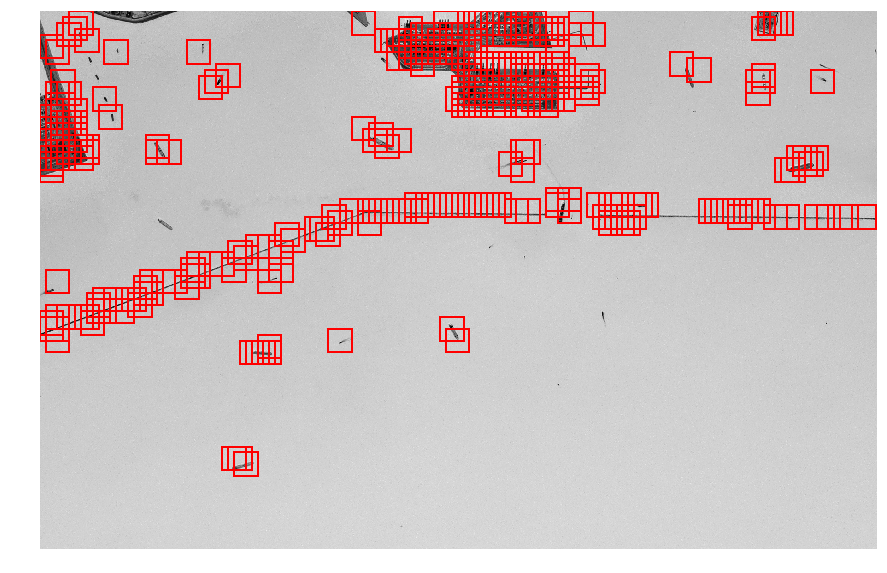

In [28]:
svc_scene_sections, svc_scene_locations, svc_scene_bw = section_scene('lb_2.png')
svc_scene_predictions = svc_clf.predict(svc_scene_sections)
mark_predictions(svc_scene_sections, svc_scene_locations, svc_scene_predictions, svc_scene_bw)

## PCA

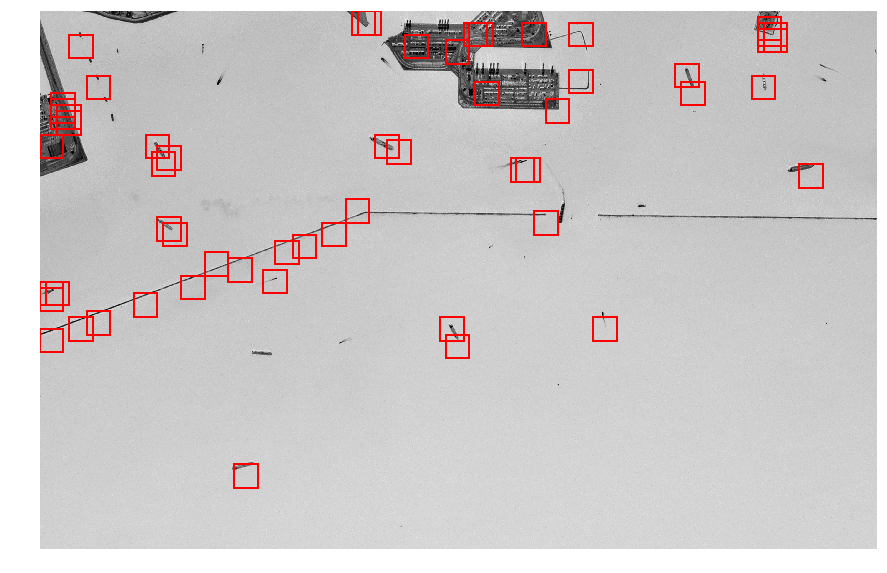

In [29]:
pca_scene_sections, pca_scene_locations, pca_scene_bw = section_scene('lb_2.png')
pca_scene_predictions = pca_clf.predict(pca.transform(pca_scene_sections))
mark_predictions(pca_scene_sections, pca_scene_locations, pca_scene_predictions, pca_scene_bw)

In [30]:
# This function allows you to browse the classifiers predictions alongside the sections 
# of the scene they're classifying
image_sections = np.array(pca_scene_sections).reshape([np.asarray(pca_scene_sections).shape[0],80,80])
image_predictions = pca_scene_predictions
browse_images(image_sections, image_predictions, ['Not Boat', 'Boat'])


interactive(children=(IntSlider(value=13771, description='i', max=27543), Output()), _dom_classes=('widget-interact',))

# Applying CNN Model

Note: The CNN Model didn't work by the end of the project. Likely due to needing more training time, the model classifies only '0' or 'not boat'. While we expect that it could reach very high performance, this is outside the scope of our project.

In [40]:
TRAIN = False
if TRAIN:
    cnn_clf = MLPClassifier(solver='sgd', alpha=1e-4, hidden_layer_sizes=(1000,750,500), max_iter=2000, random_state=1)
    cnn_clf = cnn_clf.fit(train_vectors, train_labels)
    pickle.dump(cnn_clf, open('MLP_Classifier.p', 'wb'))
else:
    cnn_clf = pickle.load(open('Classifiers/MLP_classifier.p', 'rb'))
    

In [41]:
cnn_predictions = cnn_clf.predict(test_vectors)
sum(cnn_predictions == test_labels)/len(test_labels)

0.74375

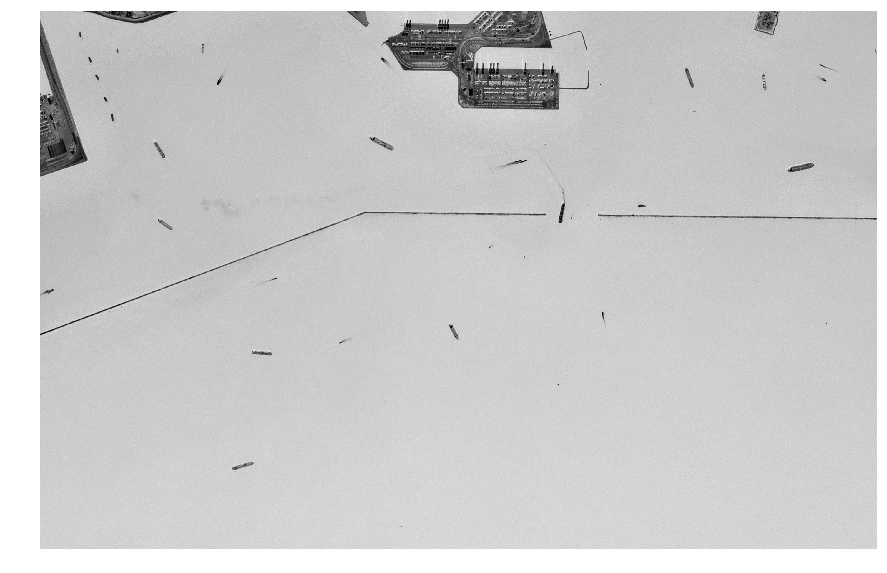

In [42]:
cnn_scene_sections, cnn_scene_locations, cnn_scene_bw = section_scene('lb_2.png')
cnn_scene_predictions = cnn_clf.predict(cnn_scene_sections)
mark_predictions(cnn_scene_sections, cnn_scene_locations, cnn_scene_predictions, cnn_scene_bw)

In [35]:
# This function allows you to browse the classifiers predictions alongside the sections 
# of the scene they're classifying
image_sections = np.array(cnn_scene_sections).reshape([np.asarray(cnn_scene_sections).shape[0],80,80])
image_predictions = cnn_scene_predictions
browse_images(image_sections, image_predictions, ['Not Boat', 'Boat'])

interactive(children=(IntSlider(value=13771, description='i', max=27543), Output()), _dom_classes=('widget-interact',))